In [9]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
#load data

data = pd.read_csv('../../../data/processed/processed2.csv')

print(data.head())
datetimes = pd.to_datetime(data['datetime_au'])
# Drop non-numeric columns (e.g., datetime)
data = data[['avg_30_min_demand', 'avg_temp']]
def create_sequences(data, seq_length):
    """
    Convert a 2D tensor of shape (total_samples, num_features) into 
    sequences of shape (num_sequences, seq_length, num_features)
    """
    sequences = []
    for i in range(len(data) - seq_length):
        # Get sequence of features
        seq = data[i:i+seq_length]
        sequences.append(seq)
    
    return torch.stack(sequences)

def create_targets(data, seq_length):
    """Create targets for each sequence (the next value after the sequence)"""
    targets = []
    for i in range(seq_length, len(data)):
        # For demand forecasting, you might want to predict only demand
        # target = data[i, 0]  # 0th column is demand
        # Or predict both features (less common)
        target = data[i]  # next full data point
        targets.append(target)
    
    return torch.stack(targets)

# Convert to numpy array and then to torch tensor
data_tensor = torch.tensor(data.values, dtype=torch.float32)
print(data.head())
print(data_tensor.shape)

# Create sequences
seq_length = 7
data_sequences = create_sequences(data_tensor, seq_length)
print(f"Data sequences shape: {data_sequences.shape}")

# Create targets (the next day's value after each sequence)
targets_demand = create_targets(data_tensor[:, 0:1], seq_length)

# Prepare Data
# 2. Scale the data (important for neural networks)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

scaled_data = scaler_X.fit_transform(data_tensor.numpy())
scaled_data = torch.FloatTensor(scaled_data)

# 3. Create sequences and targets
seq_length = 7
input_dim = 2  # demand and temperature

sequences = []
targets = []

for i in range(len(scaled_data) - seq_length):
    sequences.append(scaled_data[i:i+seq_length])  # sequence of 7 days
    targets.append(scaled_data[i+seq_length, 0])   # predict next day's demand (column 0)

sequences = torch.stack(sequences)
targets = torch.FloatTensor(targets).unsqueeze(1)  # shape: (n, 1)

print(f"Sequences shape: {sequences.shape}")  # torch.Size([1454, 7, 2])
print(f"Targets shape: {targets.shape}")      # torch.Size([1454, 1])

  datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0  2016-01-01          1          0          0          0          0   
1  2016-01-02          1          0          0          0          0   
2  2016-01-03          1          0          0          0          1   
3  2016-01-04          1          0          0          0          0   
4  2016-01-05          1          0          0          0          0   

   is_monday  is_tuesday  is_wednesday  is_thursday  ...  max_30_min_demand  \
0          0           0             0            0  ...            7913.75   
1          0           0             0            0  ...            7390.04   
2          0           0             0            0  ...            7328.39   
3          1           0             0            0  ...            8313.11   
4          0           1             0            0  ...            8338.82   

   sum_30_min_demand  count_30_min_points   avg_temp  min_temp  max_temp  \
0          32935

In [19]:
#helper functions and classes

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        src_projected = self.input_projection(src) * math.sqrt(self.d_model)
        src_projected = self.pos_encoder(src_projected)
        encoder_output = self.transformer_encoder(src_projected, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        last_time_step_output = encoder_output[:, -1, :]
        output = self.output_layer(last_time_step_output)
        return output

def train_transformer_model(sequences, targets, input_dim, seq_length, datetimes):
    """Train the Transformer model"""
    datetimes = pd.to_datetime(datetimes)
    train_mask = datetimes.dt.year != 2019
    test_mask  = datetimes.dt.year == 2019
    seq_train_mask = train_mask[seq_length:].to_numpy()
    seq_test_mask  = test_mask[seq_length:].to_numpy()
    X_train, y_train = sequences[seq_train_mask], targets[seq_train_mask]
    X_val,   y_val   = sequences[seq_test_mask], targets[seq_test_mask]
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor   = torch.FloatTensor(X_val)
    y_train_tensor = torch.FloatTensor(y_train)
    y_val_tensor   = torch.FloatTensor(y_val)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = TransformerModel(
        input_dim=input_dim,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.1
    ).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    num_epochs = 100
    patience = 100
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_X.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                val_loss += loss.item() * batch_X.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_transformer_model.pth')
        else:
            epochs_no_improve += 1
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.6f}, '
                  f'Val Loss: {val_loss:.6f}, '
                  f'LR: {optimizer.param_groups[0]["lr"]:.2e}')
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    model.load_state_dict(torch.load('best_transformer_model.pth'))
    return model, train_losses, val_losses

def evaluate_model(model, X_val, y_val, device):
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_val).to(device)
        predictions = model(X_val_tensor)
        predictions = predictions.cpu().numpy()
    return predictions

def plot_results(train_losses, val_losses, y_val, predictions):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title('Training History')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(y_val[:100], label='Actual', alpha=0.7)
    ax2.plot(predictions[:100], label='Predicted', alpha=0.7)
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Demand')
    ax2.set_title('Predictions vs Actual (First 100 samples)')
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

In [12]:
import torch
print(torch.cuda.is_available())   # should be True
print(torch.cuda.get_device_name(0))  # should print your GPU model


True
NVIDIA GeForce GTX 1650 Ti
NVIDIA GeForce GTX 1650 Ti


Using device: cuda
Epoch [10/100], Train Loss: 0.395803, Val Loss: 0.428891, LR: 1.00e-03
Epoch [10/100], Train Loss: 0.395803, Val Loss: 0.428891, LR: 1.00e-03
Epoch [20/100], Train Loss: 0.317969, Val Loss: 0.372425, LR: 1.00e-03
Epoch [20/100], Train Loss: 0.317969, Val Loss: 0.372425, LR: 1.00e-03
Epoch [30/100], Train Loss: 0.303395, Val Loss: 0.330934, LR: 1.00e-03
Epoch [30/100], Train Loss: 0.303395, Val Loss: 0.330934, LR: 1.00e-03
Epoch [40/100], Train Loss: 0.266978, Val Loss: 0.327868, LR: 5.00e-04
Epoch [40/100], Train Loss: 0.266978, Val Loss: 0.327868, LR: 5.00e-04
Epoch [50/100], Train Loss: 0.253757, Val Loss: 0.353701, LR: 5.00e-04
Epoch [50/100], Train Loss: 0.253757, Val Loss: 0.353701, LR: 5.00e-04
Epoch [60/100], Train Loss: 0.221101, Val Loss: 0.353334, LR: 1.25e-04
Epoch [60/100], Train Loss: 0.221101, Val Loss: 0.353334, LR: 1.25e-04
Epoch [70/100], Train Loss: 0.212386, Val Loss: 0.347566, LR: 3.13e-05
Epoch [70/100], Train Loss: 0.212386, Val Loss: 0.347566, 

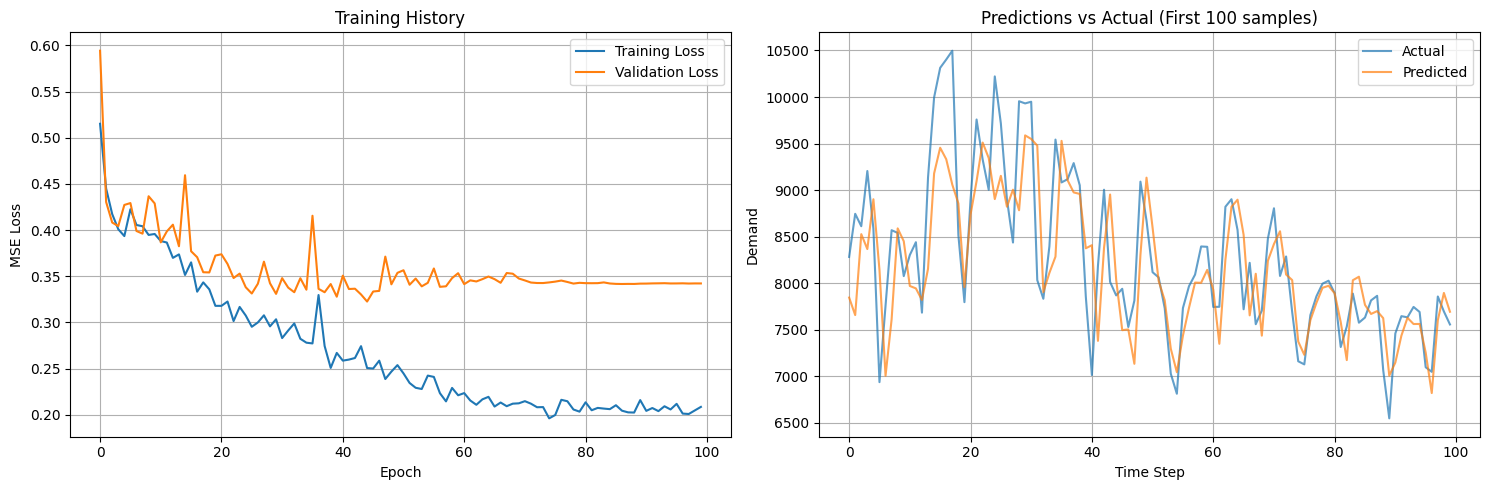

Training completed and model saved!


In [21]:
# 4. Train the model
model, train_losses, val_losses = train_transformer_model(sequences, targets, input_dim, seq_length, datetimes)

# 5. Evaluate and plot results
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_mask = pd.to_datetime(datetimes).dt.year == 2019
seq_mask = test_mask[seq_length:].to_numpy()
predictions = evaluate_model(model, sequences[seq_mask], targets[seq_mask], device)

# Inverse transform predictions to original scale
# Create dummy array for inverse transform
dummy = np.zeros((len(predictions), 2))
dummy[:, 0] = predictions.flatten()
predictions_original = scaler_X.inverse_transform(dummy)[:, 0]

dummy[:, 0] = targets[seq_mask].numpy().flatten()
targets_original = scaler_X.inverse_transform(dummy)[:, 0]

# Calculate metrics
mse = np.mean((predictions_original - targets_original) ** 2)
mae = np.mean(np.abs(predictions_original - targets_original))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((predictions_original - targets_original) / targets_original)) * 100

print(f"\nFinal Metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")

# Plot results
plot_results(train_losses, val_losses, targets_original, predictions_original)

# 6. Save the final model
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'seq_length': seq_length,
    'input_dim': input_dim
}, 'final_transformer_model.pth')

print("Training completed and model saved!")